# Configuración en Google Drive
- Ejecutar las siguientes celdas si se trabajará con el presente Jupyter Notebook en Google Drive.
- En caso de ejecutarlo en una PC local, omitir estas celdas.
- Clonar el repositorio de GitHub en su computadora local.
- Subir a Google Drive el directorio "boussineq" que se encuentra en la carpeta "uba/projects".

De esta manera, toda ejecución en el Jupyter Notebook que produzca archivos de salida serán almacenados en las carpetas internas del proyecto de forma consistente.

### Instrucciones

1) Instalar paquetes necesarios a través de pip.
2) Importar paquetes necesarios.
3) Montar Google Drive.
4) Definir rutas dentro del proyecto.
5) Importar paquetes propios.

In [ ]:
%%capture
!pip install numpy scipy matplotlib 
!pip install pyDOE gdown
!pip install torch torchvision torchaudio
!pip install pytorch-lightning

In [ ]:
import os, sys, time, json, torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
ROOT = "/content/drive/MyDrive/boussineq/"
MODELS_PATH = ROOT + "models/"
FIGURES_PATH = ROOT + "figures/"
METRICS_PATH = ROOT + "metrics/"
SOURCE_PATH = ROOT + "src/"

In [ ]:
sys.path.append(SOURCE_PATH)
from src.ic import *
from src.bc import *
from src.domain import *
from src.pinn import *

# Configuración en PC local
- Ejecutar las siguientes celdas si se trabajará con el presente Jupyter Notebook en una PC local.
- En caso de ejecutarlo en Google Drive, omitir estas celdas.
- Clonar el repositorio de GitHub en su computadora local.
- Abrir el proyecto con su entorno de desarrollo (e.g. VSCode).

De esta manera, toda ejecución en el Jupyter Notebook que produzca archivos de salida serán almacenados en las carpetas internas del proyecto de forma consistente, dentro de la carpeta "boussineq", localmente.

### Instrucciones

1) Instalar paquetes necesarios a través de pip (ejecutar las intrucciones para crear el entorno virtual). Los paquetes necesarios se encuentran en el archivo *requirements.txt*. Las intrucciones se encuentran en el archivo *README.md*.
2) Importar paquetes necesarios.
3) Importar paquetes propios.
4) Definir rutas dentro del proyecto.


In [1]:
import os, time, json, torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

# Importar paquetes propios
from src.ic import *
from src.bc import *
from src.domain import *
from src.pinn import *

In [2]:
ROOT = os.getcwd()
MODELS_PATH = ROOT + "/models/"
FIGURES_PATH = ROOT + "/figures/"
METRICS_PATH = ROOT + "/metrics/"
SOURCE_PATH = ROOT + "/src/"

# Resolución Ecuación de Boussinesq

#### Configuración del dispositivo (device)

In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Usando MPS (Apple GPU)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Usando CUDA (NVIDIA GPU)")
else:
    device = torch.device("cpu")
    print("Usando CPU")

Usando MPS (Apple GPU)


#### Construcción del Dataset
- Condición inicial
- Condiciones de frontera izquierda y derecha
- Dominio
- El dataset se subdivide en train y validation

In [4]:
# Número de puntos y tamaño de batch
n_ic = 200
n_bc = 200
n_domain = 10000
batch_size_ic = 32
batch_size_bc = 32
batch_size_domain = 128

In [5]:
ic_dl = getICDataLoader(n=n_ic, batch_size=batch_size_ic)
bc_left_dl, bc_right_dl = getBCDataLoader(n=n_bc, batch_size=batch_size_bc)
domain_dl = getDomainDataLoader(n=n_domain, batch_size=batch_size_domain)

train_dl = (ic_dl[0], bc_left_dl[0], bc_right_dl[0], domain_dl[0])
val_dl = (ic_dl[1], bc_left_dl[1], bc_right_dl[1], domain_dl[1])

#### Visualización de los puntos de collocación
- Puntos de condición inicial
- Puntos de condición de frontera izquierda y derecha
- Puntos de dominio

In [6]:
X_ic = []
for tx_batch, _ in train_dl[0]:
    X_ic.append(tx_batch.detach().cpu().numpy())
X_ic = np.concatenate(X_ic, axis=0)

X_left, X_right = [], []
for left_tx_batch, right_tx_batch in zip(train_dl[1], train_dl[2]):
    X_left.append(left_tx_batch.detach().cpu().numpy())
    X_right.append(right_tx_batch.detach().cpu().numpy())
X_left = np.concatenate(X_left, axis=0)
X_right = np.concatenate(X_right, axis=0)

X_domain = []
for tx_batch in train_dl[3]:
    X_domain.append(tx_batch.detach().cpu().numpy())
X_domain = np.concatenate(X_domain, axis=0)

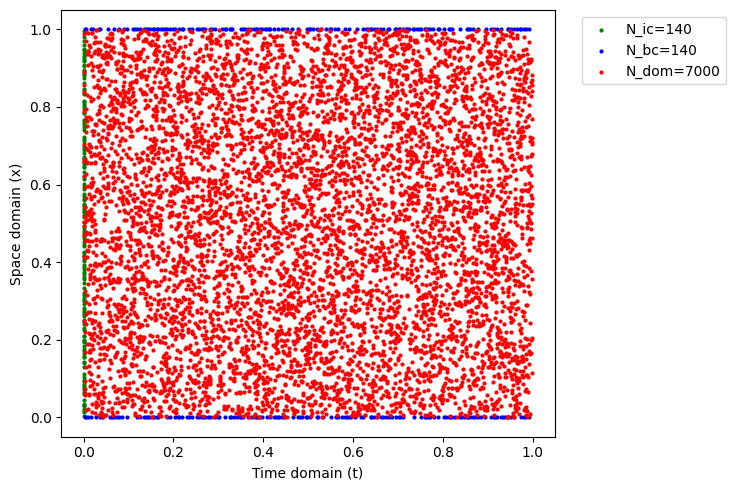

In [7]:
# Plot the locations of the collocation points in the space-time domain
fig = plt.figure(figsize=(7.5, 5))
ax = fig.add_subplot(111)
ax.scatter(X_ic[:, 0:1], X_ic[:, 1:2], s=4, c='g', label=f'N_ic={X_ic.shape[0]}')
ax.scatter(X_left[:, 0:1], X_left[:, 1:2], s=4, c='b', label=f'N_bc={X_left.shape[0]}')
ax.scatter(X_right[:, 0:1], X_right[:, 1:2], s=4, c='b')
ax.scatter(X_domain[:, 0:1], X_domain[:, 1:2], s=4, c='r', label=f'N_dom={X_domain.shape[0]}')
ax.legend(loc='best')
plt.xlabel('Time domain (t)')
plt.ylabel('Space domain (x)')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.tight_layout()
plt.savefig(FIGURES_PATH + '/collocation_points.png', dpi=300, facecolor='w', edgecolor='w')
plt.show()

#### Definición del modelo
- Número de neuronas y activaciones
- Ruta de guardado del modelo
- Ruta de guardado de las métricas
- Carga del modelo y las métricas si existen

In [6]:
hn, hl = 128, 4
sizes = [2] + [hn] * hl + [1]
activations = [nn.Tanh()] * hl
model_path = os.path.join(MODELS_PATH, 'model.pth')
metrics_path = os.path.join(METRICS_PATH, 'metrics.txt')

model = PINN(sizes, activations, device=device)
model.initializeLambda(ic=10.0, bc=10.0, domain=1.0)
model.to(device)

if os.path.exists(model_path) and os.path.exists(metrics_path):
    model.load(model_path, metrics_path)

#### Entrenamiento del modelo
- Optimizador
- Número de épocas
- Tasa de aprendizaje
- Regularización
- Frecuencia de impresión
- Pérdida ponderada
- Factor de ponderación
- Factor de ponderación para la pérdida del dominio

In [7]:
model.fit(train_dataloader=train_dl, 
          optimizer=optim.AdamW, 
          val_dataloader=val_dl, 
          epochs=250, 
          lr=1e-4, 
          regularization=1e-5, 
          epoch_print=50,
          weighted_loss=True,
          alpha=0.8,
          epoch_refresh=100)
model.save(model_path, metrics_path)
model.plotLoss(save=True, filename=FIGURES_PATH + '/loss.png')

Epoch 1800/2001: Loss (0.01544, 0.003068)
Epoch 1850/2001: Loss (0.02263, 0.004435)
Epoch 1900/2001: Loss (0.03648, 0.007701)
Epoch 1950/2001: Loss (0.01596, 0.003377)
Epoch 2000/2001: Loss (0.01298, 0.002725)


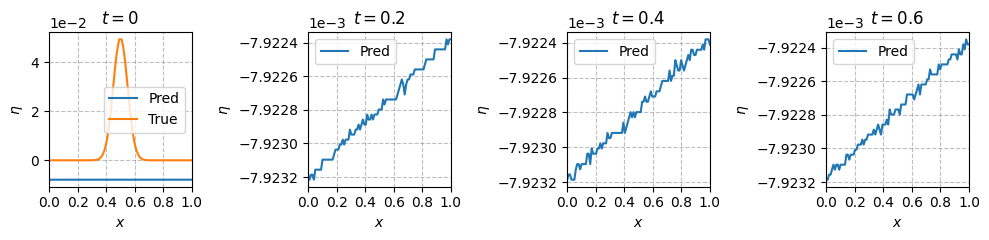

In [8]:
# Plot in 4 subplots (horizontally).
# 1st frame: initial condition (true and predicted)
# 2nd frame: solution at t=0.2
# 3rd frame: solution at t=0.4
# 4th frame: solution at t=0.6

fig, axs = plt.subplots(1, 4, figsize=(10, 2.5))

# t = 0
ic_tx, ic_eta = gaussian(n=100)
idxs = ic_tx[:, 1].argsort()
ic_tx = ic_tx[idxs]
ic_eta = ic_eta[idxs]
ic_tx = torch.tensor(ic_tx, dtype=torch.float32)
ic_eta_pred = model.forward(ic_tx.to(device)).detach().cpu().numpy()
ic_tx = ic_tx.cpu().numpy()
# plot t=0
axs[0].plot(ic_tx[:, 1], ic_eta_pred[:, 0], label='Pred')
axs[0].plot(ic_tx[:, 1], ic_eta[:, 0], label='True')
axs[0].set_title('$t = 0$')

# t = 0.2
x = np.linspace(0, 1, 100).reshape(-1, 1)
t = 0.2 * np.ones_like(x)
tx = np.concatenate((t, x), axis=1)
tx = torch.tensor(tx, dtype=torch.float32)
eta_pred = model.forward(tx.to(device)).detach().cpu().numpy()
tx = tx.cpu().numpy()
# plot t=0.2
axs[1].plot(tx[:, 1], eta_pred[:, 0], label='Pred')
axs[1].set_title('$t = 0.2$')

# t = 0.4
t = 0.4 * np.ones_like(x)
tx = np.concatenate((t, x), axis=1)
tx = torch.tensor(tx, dtype=torch.float32)
eta_pred = model.forward(tx.to(device)).detach().cpu().numpy()
tx = tx.cpu().numpy()
# plot t=0.4
axs[2].plot(tx[:, 1], eta_pred[:, 0], label='Pred')
axs[2].set_title('$t = 0.4$')

# t = 0.6
t = 0.6 * np.ones_like(x)
tx = np.concatenate((t, x), axis=1)
tx = torch.tensor(tx, dtype=torch.float32)
eta_pred = model.forward(tx.to(device)).detach().cpu().numpy()
tx = tx.cpu().numpy()
# plot t=0.6
axs[3].plot(tx[:, 1], eta_pred[:, 0], label='Pred')
axs[3].set_title('$t = 0.6$')

for ax in axs.flatten():
    ax.set_xlim(0, 1)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\eta$')
    ax.legend(loc='best')
    # use scientific notation for y axis but always between 0 and 1e-1
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, -1))
    ax.set_xticks(np.arange(0, 1.01, 0.2))
    #ax.set_yticks([5e-2, 4e-2, 2e-2, 1e-2, 0])
    ax.grid(True, which='both', ls='--', alpha=0.5, c='gray')

plt.tight_layout()
plt.savefig(FIGURES_PATH + '/solution.png', dpi=300, facecolor='w', edgecolor='w')
plt.show()


In [ ]:
print(f"Lambda: {model.lambda_ic:.4g}, {model.lambda_bc:.4g}, {model.lambda_domain:.4g}")